# Feature Importance

Author: Yi Huang

In [163]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## Why we care about feature importance?

* Feature Selection: Algorithms like tree based models (e.g. LightGBM, XGBoost) can handle a large amount of features pretty well without feature selection, whereas feature selection is still extremely helpful. 1. Many features will introduce noise into the dataset, in such case your models are likely to overfit and give you a false feeling of good performance. 2. It will reduce the running time of training your algorithm, as well as meet the low latency requirement after deploying your model into use. 3. More comprehendible to humans. Feature importance facilitates choosing the right features.
* Explanatory Analysis: Machine learning is not always about higher prediction power, sometimes we want to open the blackbox and see the underlying secrets about the data. Explanatory analysis is becoming more and more important in the data science world. It's an essential tool to find the key players in your analysis. Feature importance helps you find these key features and their relationship with the target variable.

### Load data (already preprocessed) <br>
This dataset is from a public Kaggle dataset. I already cleaned this dataset and downsampled it in order to have better performance for this feature importance project. <br>

The reason why I choose this dataset: In financial companies, feature importance is critical for guiding the risk management, marketing strategy, customer management, etc. People want to know what are the <b>"North Star"</b> factors influence their businesses <br>

Dataset Link: https://www.kaggle.com/mlg-ulb/creditcardfraud <br>

In [2]:
df = pd.read_csv('creditcard_down.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [14]:
df['Time'].values

array([   406.,    472.,   4462., ..., 158425., 140271.,  73886.])

In [75]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns


def importance_plot(importance_dict):
    col_name = importance_dict.keys()
    col_importance = importance_dict.values()
    importance_df = pd.DataFrame()
    importance_df['col_name'] = col_name
    importance_df['col_importance'] = col_importance
    importance_df = importance_df.sort_values(by=['col_importance'],ascending=False)
    sns.set_context('paper')
    f, ax = plt.subplots(figsize = (6,15))
    sns.set_color_codes('pastel')
    sns.barplot(x = 'col_importance', y = 'col_name', data = importance_df,
                label = 'Total', color = 'b', edgecolor = 'w')
    sns.set_color_codes('muted')
    sns.despine(left = True, bottom = True)
    plt.show()

# Spearman Ranking

The first method to ...

In [77]:
from collections import defaultdict
from scipy import stats
def spearman_ranking(df,target,absolute = False):
    corr_result = defaultdict(float)
    col_list = list(df.columns)
    col_list.remove(target)
    target_value = df[target].values
    for item in col_list:
        col_value = df[item].values
        corr_value,_ = stats.spearmanr(col_value, target_value)
        if absolute:
            corr_result[item] = abs(corr_value)
        else:
            corr_result[item] = corr_value
    return corr_result

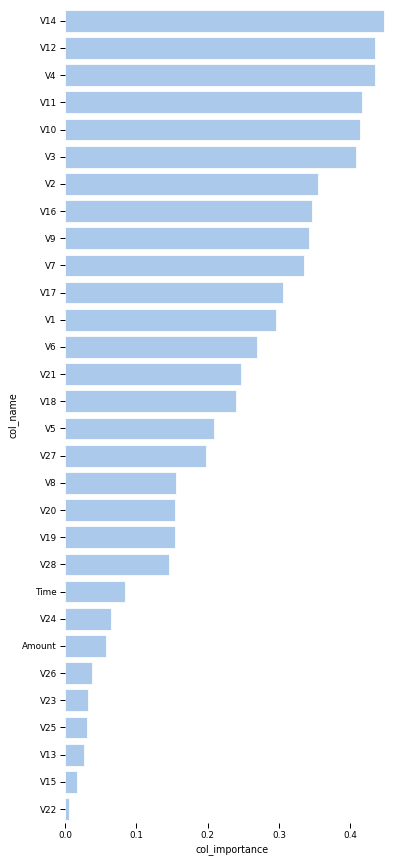

In [186]:
importance_spearman = spearman_ranking(df,'Class',absolute = True)
importance_plot(importance_spearman)

# PCA Ranking

In [79]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
def pca_ranking(df,target,n_components=8,absolute = False):
    col_list = list(df.columns)
    col_list.remove(target)
    data_scaled = pd.DataFrame(preprocessing.scale(X),columns = col_list) 
    pca = PCA(n_components)
    pca.fit(data_scaled)
    explained_variance = pca.explained_variance_ratio_[0] # extract first component
    print(f'Explained variance for the first component:{explained_variance}')
    weight = pca.components_[0]
    corr_result = defaultdict(float)
    for i in range(len(col_list)):
        if absolute:
            corr_result[col_list[i]] = abs(weight[i])
        else:
            corr_result[col_list[i]] = weight[i]
    return corr_result

Explained variance for the first component:0.3007450183523831


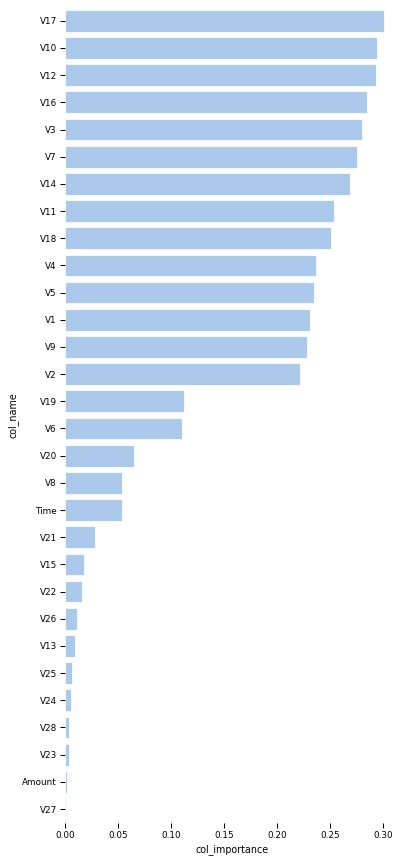

In [187]:
importance_pca = pca_ranking(df,'Class',absolute = True)
importance_plot(importance_pca)

# Minimal Redundancy Maximal Relevance (mRMR)

In [66]:
def mrmr_ranking(df,target):
    corr_result = defaultdict(float)
    corr_table = df.corr('spearman')
    col_list = list(df.columns)
    col_list.remove(target) 
    S = len(col_list) - 1 
    for item in col_list:
        corr_y = corr_table[item][target]
        corr_x = corr_table[item]
        corr_x = corr_x.drop([target, item], axis = 0)
        corr_result[item] = abs(corr_y) - sum([abs(x) for x in corr_x]) / S
    return corr_result

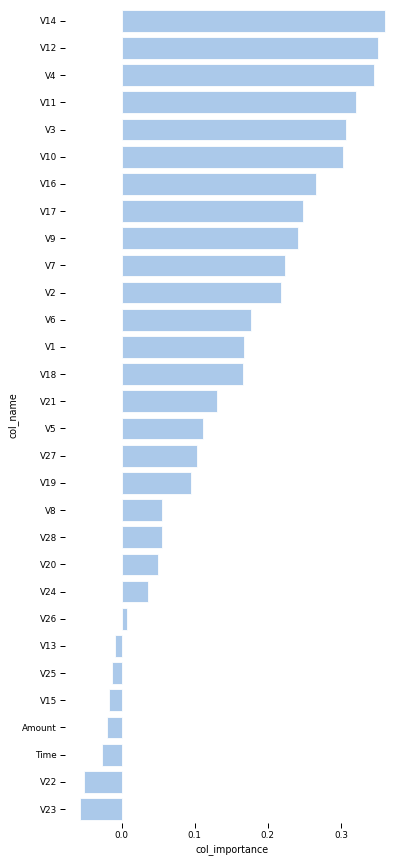

In [188]:
importance_mRMR = mrmr_ranking(df,'Class')
importance_plot(importance_mRMR)

# Model Based Ranking

Some models have build-in feature importance. The default feature importance for random forest might be misleading, here we borrow the idea of <b>permutation importance</b> and <b>drop column importance</b>. <br>
Here is an link to the article: https://explained.ai/rf-importance/index.html

### Model Training with Optuna

In [100]:
from   sklearn.model_selection import train_test_split
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Split data with balanced class
X_train, X_valid, y_train, y_valid = train_test_split(X, y,random_state = 42,test_size = 0.2,stratify=y)

In [101]:
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

In [103]:
import optuna
from optuna._imports import try_import
from optuna.integration import _lightgbm_tuner as tuner
from sklearn.model_selection import KFold
import lightgbm as lgb
from lightgbm import LGBMClassifier

def objective(trial, return_info=False):
    folds = 5
    seed = 42
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        #'learning_rate': 0.1,
        'verbosity': -1,
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth':trial.suggest_int('max_depth',5,15)
    }

    
    models = []
    valid_score = 0
    losses = []
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_x,train_y = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_x,valid_y = X_train.iloc[valid_idx,:], y_train[valid_idx]
        d_train = lgb.Dataset(train_x,train_y)
        d_valid = lgb.Dataset(valid_x,valid_y)
        watchlist = [d_train, d_valid]
        early_stop = 20
        verbose_eval = 20
        model = lgb.train(param,
                          train_set=d_train,
                          num_boost_round=1500,
                          valid_sets=watchlist,
                          verbose_eval=verbose_eval,
                          early_stopping_rounds=early_stop)
        y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
        
        print('best_score', model.best_score)
        log = {'train': model.best_score['training']['binary_logloss'],
               'valid': model.best_score['valid_1']['binary_logloss']} 
        
        models.append(model)
        valid_score += log["valid"]
    valid_score /= len(models)
    
    if return_info:
        return valid_score, models
    else:
        return valid_score
study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2021-05-08 23:18:18,977] A new study created in memory with name: no-name-cda94b2d-6aa3-4e4c-9155-45276803a0e3


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0514483	valid_1's binary_logloss: 0.0652924
[40]	training's binary_logloss: 0.0218278	valid_1's binary_logloss: 0.0558807
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0236923	valid_1's binary_logloss: 0.0551824
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023692339561795936)]), 'valid_1': OrderedDict([('binary_logloss', 0.055182427274460336)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0510271	valid_1's binary_logloss: 0.0653282
[40]	training's binary_logloss: 0.0190761	valid_1's binary_logloss: 0.0506414
[60]	training's binary_logloss: 0.00996242	valid_1's binary_logloss: 0.0565179
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0190761	valid_1's binary_logloss: 0.0506414
best_score defaultdict(<class 'collections.OrderedDict'>, {'trai

[I 2021-05-08 23:18:20,178] Trial 0 finished with value: 0.06750761661569979 and parameters: {'lambda_l1': 2.2000490961988413e-07, 'lambda_l2': 0.03656351863565525, 'num_leaves': 85, 'feature_fraction': 0.5486320803376672, 'bagging_fraction': 0.4452972575445071, 'bagging_freq': 5, 'min_child_samples': 12, 'max_depth': 13}. Best is trial 0 with value: 0.06750761661569979.


[20]	training's binary_logloss: 0.0501388	valid_1's binary_logloss: 0.0911094
[40]	training's binary_logloss: 0.0232691	valid_1's binary_logloss: 0.0881162
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0351363	valid_1's binary_logloss: 0.0859042
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03513631449337313)]), 'valid_1': OrderedDict([('binary_logloss', 0.0859041562263218)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0676654	valid_1's binary_logloss: 0.0677602
[40]	training's binary_logloss: 0.0322361	valid_1's binary_logloss: 0.0489626
[60]	training's binary_logloss: 0.0173257	valid_1's binary_logloss: 0.0487708
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.025039	valid_1's binary_logloss: 0.0485084
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02503895507443648)]), 'va

[I 2021-05-08 23:18:21,084] Trial 1 finished with value: 0.060961223351276496 and parameters: {'lambda_l1': 0.013754660594359789, 'lambda_l2': 5.244914596660679e-08, 'num_leaves': 48, 'feature_fraction': 0.588192222299194, 'bagging_fraction': 0.9784384790201429, 'bagging_freq': 7, 'min_child_samples': 98, 'max_depth': 6}. Best is trial 1 with value: 0.060961223351276496.


[40]	training's binary_logloss: 0.0291781	valid_1's binary_logloss: 0.0795091
[60]	training's binary_logloss: 0.0139964	valid_1's binary_logloss: 0.080745
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0270475	valid_1's binary_logloss: 0.0791228
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.027047475908243846)]), 'valid_1': OrderedDict([('binary_logloss', 0.0791227865040671)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0657008	valid_1's binary_logloss: 0.0693298
[40]	training's binary_logloss: 0.033818	valid_1's binary_logloss: 0.0559509
[60]	training's binary_logloss: 0.02014	valid_1's binary_logloss: 0.0555232
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.027043	valid_1's binary_logloss: 0.0549887
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.027043012461965603)]), 'vali

[I 2021-05-08 23:18:22,216] Trial 2 finished with value: 0.0636471238543641 and parameters: {'lambda_l1': 1.2754055852143245, 'lambda_l2': 0.006926715967505453, 'num_leaves': 92, 'feature_fraction': 0.9646859491171584, 'bagging_fraction': 0.5800724694984545, 'bagging_freq': 3, 'min_child_samples': 32, 'max_depth': 11}. Best is trial 1 with value: 0.060961223351276496.


[60]	training's binary_logloss: 0.0206436	valid_1's binary_logloss: 0.0842316
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.029841	valid_1's binary_logloss: 0.0811982
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.029840975526643904)]), 'valid_1': OrderedDict([('binary_logloss', 0.08119816768496062)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0734199	valid_1's binary_logloss: 0.0716695
[40]	training's binary_logloss: 0.0393788	valid_1's binary_logloss: 0.0543879
[60]	training's binary_logloss: 0.0230058	valid_1's binary_logloss: 0.0511145
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0238575	valid_1's binary_logloss: 0.0509777
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023857502074431002)]), 'valid_1': OrderedDict([('binary_logloss', 0.05097768130269037)])})
Training u

[I 2021-05-08 23:18:23,690] Trial 3 finished with value: 0.06251682899323642 and parameters: {'lambda_l1': 0.45873497103689237, 'lambda_l2': 0.008410264114030416, 'num_leaves': 35, 'feature_fraction': 0.6517746553279253, 'bagging_fraction': 0.6750772074910008, 'bagging_freq': 6, 'min_child_samples': 89, 'max_depth': 10}. Best is trial 1 with value: 0.060961223351276496.


[80]	training's binary_logloss: 0.0139827	valid_1's binary_logloss: 0.0870891
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.022724	valid_1's binary_logloss: 0.080938
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.022723964590105464)]), 'valid_1': OrderedDict([('binary_logloss', 0.08093800867056394)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0664096	valid_1's binary_logloss: 0.068898
[40]	training's binary_logloss: 0.0310141	valid_1's binary_logloss: 0.0513752
[60]	training's binary_logloss: 0.0148015	valid_1's binary_logloss: 0.0526487
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0262642	valid_1's binary_logloss: 0.049474
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02626418346316445)]), 'valid_1': OrderedDict([('binary_logloss', 0.049473979883628186)])})
Training unti

[I 2021-05-08 23:18:24,715] Trial 4 finished with value: 0.06111371669203165 and parameters: {'lambda_l1': 2.2764628328477064e-07, 'lambda_l2': 0.01368321043248287, 'num_leaves': 18, 'feature_fraction': 0.5213407084031897, 'bagging_fraction': 0.698336402122194, 'bagging_freq': 3, 'min_child_samples': 57, 'max_depth': 6}. Best is trial 1 with value: 0.060961223351276496.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0626767	valid_1's binary_logloss: 0.0942138
[40]	training's binary_logloss: 0.0279558	valid_1's binary_logloss: 0.0780369
[60]	training's binary_logloss: 0.0141003	valid_1's binary_logloss: 0.0847955
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0279558	valid_1's binary_logloss: 0.0780369
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.027955840812235944)]), 'valid_1': OrderedDict([('binary_logloss', 0.0780369254043974)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0658118	valid_1's binary_logloss: 0.0680437
[40]	training's binary_logloss: 0.0287375	valid_1's binary_logloss: 0.0517449
[60]	training's binary_logloss: 0.0129955	valid_1's binary_logloss: 0.051485
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0209976	valid_1's binary_logloss: 

[I 2021-05-08 23:18:25,921] Trial 5 finished with value: 0.06240340476306785 and parameters: {'lambda_l1': 3.2380446300186013e-06, 'lambda_l2': 4.008681129683594e-05, 'num_leaves': 36, 'feature_fraction': 0.5988133292341311, 'bagging_fraction': 0.7833604854527807, 'bagging_freq': 6, 'min_child_samples': 75, 'max_depth': 9}. Best is trial 1 with value: 0.060961223351276496.


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0233379	valid_1's binary_logloss: 0.0657775
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023337920371459417)]), 'valid_1': OrderedDict([('binary_logloss', 0.06577747739774416)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0624554	valid_1's binary_logloss: 0.0934086
[40]	training's binary_logloss: 0.0288889	valid_1's binary_logloss: 0.0783895
[60]	training's binary_logloss: 0.012443	valid_1's binary_logloss: 0.0824722
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0288889	valid_1's binary_logloss: 0.0783895
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.028888863340385332)]), 'valid_1': OrderedDict([('binary_logloss', 0.07838951432666322)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logl

[I 2021-05-08 23:18:26,808] Trial 6 finished with value: 0.05995570371574523 and parameters: {'lambda_l1': 7.318069692706466e-07, 'lambda_l2': 0.00045363175440752904, 'num_leaves': 8, 'feature_fraction': 0.7367906146706873, 'bagging_fraction': 0.9604859890247271, 'bagging_freq': 1, 'min_child_samples': 67, 'max_depth': 15}. Best is trial 6 with value: 0.05995570371574523.


[60]	training's binary_logloss: 0.0196301	valid_1's binary_logloss: 0.0661605
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0314003	valid_1's binary_logloss: 0.0640283
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.031400287354509455)]), 'valid_1': OrderedDict([('binary_logloss', 0.0640282540511764)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0622265	valid_1's binary_logloss: 0.091355
[40]	training's binary_logloss: 0.0317	valid_1's binary_logloss: 0.0770548
[60]	training's binary_logloss: 0.0191854	valid_1's binary_logloss: 0.0740439
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0213038	valid_1's binary_logloss: 0.0736333
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02130381261248509)]), 'valid_1': OrderedDict([('binary_logloss', 0.07363326440747661)])})
Training until 

[I 2021-05-08 23:18:28,388] Trial 7 finished with value: 0.062305387267807946 and parameters: {'lambda_l1': 0.22650856360559785, 'lambda_l2': 1.1098751693798858, 'num_leaves': 99, 'feature_fraction': 0.5960294323323412, 'bagging_fraction': 0.9182391407053218, 'bagging_freq': 7, 'min_child_samples': 26, 'max_depth': 7}. Best is trial 6 with value: 0.05995570371574523.


[60]	training's binary_logloss: 0.0118022	valid_1's binary_logloss: 0.0672641
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0191265	valid_1's binary_logloss: 0.0646992
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.019126471872197258)]), 'valid_1': OrderedDict([('binary_logloss', 0.06469922853588585)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0570744	valid_1's binary_logloss: 0.0919755
[40]	training's binary_logloss: 0.0232728	valid_1's binary_logloss: 0.0787162
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.024178	valid_1's binary_logloss: 0.0786347
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.024178016584408858)]), 'valid_1': OrderedDict([('binary_logloss', 0.0786347479227135)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_loglo

[I 2021-05-08 23:18:29,274] Trial 8 finished with value: 0.05950488878448186 and parameters: {'lambda_l1': 7.902601989395657e-07, 'lambda_l2': 5.648254437122679e-07, 'num_leaves': 67, 'feature_fraction': 0.6998029478945647, 'bagging_fraction': 0.5584550389770908, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 5}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0209179	valid_1's binary_logloss: 0.0615759
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.020917943142016903)]), 'valid_1': OrderedDict([('binary_logloss', 0.06157585391386206)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0674198	valid_1's binary_logloss: 0.0939647
[40]	training's binary_logloss: 0.0346263	valid_1's binary_logloss: 0.0761255
[60]	training's binary_logloss: 0.0207114	valid_1's binary_logloss: 0.0786017
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0264393	valid_1's binary_logloss: 0.0749756
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.0264393386438267)]), 'valid_1': OrderedDict([('binary_logloss', 0.07497557098167412)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_loglo

[I 2021-05-08 23:18:30,486] Trial 9 finished with value: 0.06408135571934923 and parameters: {'lambda_l1': 0.0048945745699493295, 'lambda_l2': 1.4528290921151845e-07, 'num_leaves': 63, 'feature_fraction': 0.4007140164950425, 'bagging_fraction': 0.8010454899558843, 'bagging_freq': 4, 'min_child_samples': 19, 'max_depth': 13}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0232779	valid_1's binary_logloss: 0.0848527
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02327787688653032)]), 'valid_1': OrderedDict([('binary_logloss', 0.0848527343907515)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0702499	valid_1's binary_logloss: 0.0700447
[40]	training's binary_logloss: 0.0379585	valid_1's binary_logloss: 0.0554263
[60]	training's binary_logloss: 0.0215184	valid_1's binary_logloss: 0.0574882
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0356271	valid_1's binary_logloss: 0.0542554
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03562711385170154)]), 'valid_1': OrderedDict([('binary_logloss', 0.05425536209207562)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_loglos

[I 2021-05-08 23:18:31,316] Trial 10 finished with value: 0.06428310575111143 and parameters: {'lambda_l1': 4.819483483388446e-05, 'lambda_l2': 1.9758999109086655e-06, 'num_leaves': 70, 'feature_fraction': 0.8331516160374471, 'bagging_fraction': 0.40117654417891857, 'bagging_freq': 2, 'min_child_samples': 45, 'max_depth': 5}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0377145	valid_1's binary_logloss: 0.0702234
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0448944	valid_1's binary_logloss: 0.0687224
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04489439957123797)]), 'valid_1': OrderedDict([('binary_logloss', 0.06872241191724152)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0642937	valid_1's binary_logloss: 0.0933854
[40]	training's binary_logloss: 0.0370594	valid_1's binary_logloss: 0.0811859
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0400557	valid_1's binary_logloss: 0.0800907
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.040055655687308914)]), 'valid_1': OrderedDict([('binary_logloss', 0.08009068338506525)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logl

[I 2021-05-08 23:18:32,113] Trial 11 finished with value: 0.06076878929770746 and parameters: {'lambda_l1': 2.6804726230121553e-08, 'lambda_l2': 4.3858058241764106e-05, 'num_leaves': 4, 'feature_fraction': 0.779503185838722, 'bagging_fraction': 0.5346413151657698, 'bagging_freq': 1, 'min_child_samples': 66, 'max_depth': 15}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0472152	valid_1's binary_logloss: 0.0799844
[60]	training's binary_logloss: 0.0374652	valid_1's binary_logloss: 0.0790379
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.0417366	valid_1's binary_logloss: 0.0787402
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04173657058124419)]), 'valid_1': OrderedDict([('binary_logloss', 0.07874017585923075)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0719972	valid_1's binary_logloss: 0.0708897
[40]	training's binary_logloss: 0.039398	valid_1's binary_logloss: 0.0555413
[60]	training's binary_logloss: 0.0201006	valid_1's binary_logloss: 0.0561194
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0264865	valid_1's binary_logloss: 0.05415
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026486462269485984)]), 'va

[I 2021-05-08 23:18:33,117] Trial 12 finished with value: 0.06445930581888673 and parameters: {'lambda_l1': 2.7886956097891905e-05, 'lambda_l2': 0.00011507557233476769, 'num_leaves': 72, 'feature_fraction': 0.7592988569056904, 'bagging_fraction': 0.5410993715993899, 'bagging_freq': 1, 'min_child_samples': 79, 'max_depth': 15}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0342306	valid_1's binary_logloss: 0.0804143
[60]	training's binary_logloss: 0.0194306	valid_1's binary_logloss: 0.0825893
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0272346	valid_1's binary_logloss: 0.078752
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02723460808969193)]), 'valid_1': OrderedDict([('binary_logloss', 0.07875196377750991)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0803432	valid_1's binary_logloss: 0.0732963
[40]	training's binary_logloss: 0.0605251	valid_1's binary_logloss: 0.0576497
[60]	training's binary_logloss: 0.0520045	valid_1's binary_logloss: 0.0562176
[80]	training's binary_logloss: 0.0453944	valid_1's binary_logloss: 0.0548394
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0489742	valid_1's binary_logloss: 0.0540347
best_score defaultdict(<class 'collections.OrderedD

[I 2021-05-08 23:18:33,855] Trial 13 finished with value: 0.06121922782803019 and parameters: {'lambda_l1': 1.0028975736184684e-08, 'lambda_l2': 1.4111627565030697e-06, 'num_leaves': 3, 'feature_fraction': 0.8927635702106498, 'bagging_fraction': 0.6255752494627994, 'bagging_freq': 4, 'min_child_samples': 46, 'max_depth': 8}. Best is trial 8 with value: 0.05950488878448186.


[80]	training's binary_logloss: 0.0410629	valid_1's binary_logloss: 0.0647706
[100]	training's binary_logloss: 0.0359781	valid_1's binary_logloss: 0.0645337
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0374698	valid_1's binary_logloss: 0.0637517
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03746983831438407)]), 'valid_1': OrderedDict([('binary_logloss', 0.06375174377670623)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0749336	valid_1's binary_logloss: 0.0992816
[40]	training's binary_logloss: 0.0533748	valid_1's binary_logloss: 0.0837353
[60]	training's binary_logloss: 0.0457256	valid_1's binary_logloss: 0.0790296
[80]	training's binary_logloss: 0.0397715	valid_1's binary_logloss: 0.0744
[100]	training's binary_logloss: 0.0351169	valid_1's binary_logloss: 0.0743552
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0363626	valid_1's

[I 2021-05-08 23:18:35,115] Trial 14 finished with value: 0.06143572753864603 and parameters: {'lambda_l1': 1.076499121445343e-06, 'lambda_l2': 0.0006884622565673367, 'num_leaves': 55, 'feature_fraction': 0.7480435680499326, 'bagging_fraction': 0.8012923174046965, 'bagging_freq': 3, 'min_child_samples': 61, 'max_depth': 12}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0252612	valid_1's binary_logloss: 0.0765162
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02526122182713457)]), 'valid_1': OrderedDict([('binary_logloss', 0.07651620510902768)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0731857	valid_1's binary_logloss: 0.0704289
[40]	training's binary_logloss: 0.0434518	valid_1's binary_logloss: 0.0526342
[60]	training's binary_logloss: 0.0242698	valid_1's binary_logloss: 0.0449638
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0261638	valid_1's binary_logloss: 0.0448004
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026163849153752604)]), 'valid_1': OrderedDict([('binary_logloss', 0.044800417086957936)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_log

[I 2021-05-08 23:18:36,127] Trial 15 finished with value: 0.060540153202217326 and parameters: {'lambda_l1': 0.00044979021155216455, 'lambda_l2': 3.0097481046374645e-06, 'num_leaves': 17, 'feature_fraction': 0.6990587806742323, 'bagging_fraction': 0.4898749788778173, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 14}. Best is trial 8 with value: 0.05950488878448186.


[20]	training's binary_logloss: 0.0692359	valid_1's binary_logloss: 0.0957407
[40]	training's binary_logloss: 0.0418399	valid_1's binary_logloss: 0.0856598
[60]	training's binary_logloss: 0.0240841	valid_1's binary_logloss: 0.0862057
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0289916	valid_1's binary_logloss: 0.0832508
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.028991603989202887)]), 'valid_1': OrderedDict([('binary_logloss', 0.08325082449754653)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0528233	valid_1's binary_logloss: 0.0658939
[40]	training's binary_logloss: 0.0155987	valid_1's binary_logloss: 0.0514285
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0176094	valid_1's binary_logloss: 0.0513822
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.017609385606863724)]),

[I 2021-05-08 23:18:37,743] Trial 16 finished with value: 0.06277548123757647 and parameters: {'lambda_l1': 6.041394856944936e-06, 'lambda_l2': 1.0595627376731144e-08, 'num_leaves': 82, 'feature_fraction': 0.8635595996710896, 'bagging_fraction': 0.9006892172371728, 'bagging_freq': 2, 'min_child_samples': 41, 'max_depth': 10}. Best is trial 8 with value: 0.05950488878448186.


[20]	training's binary_logloss: 0.0496244	valid_1's binary_logloss: 0.0879308
[40]	training's binary_logloss: 0.0144701	valid_1's binary_logloss: 0.0792951
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0194032	valid_1's binary_logloss: 0.0792132
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.019403162456491495)]), 'valid_1': OrderedDict([('binary_logloss', 0.07921316483521346)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0789279	valid_1's binary_logloss: 0.0733231
[40]	training's binary_logloss: 0.0495867	valid_1's binary_logloss: 0.0537931
[60]	training's binary_logloss: 0.0336081	valid_1's binary_logloss: 0.0521041
[80]	training's binary_logloss: 0.0245182	valid_1's binary_logloss: 0.052332
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0274165	valid_1's binary_logloss: 0.0514923
best_score defaultdict(<class 'collections.Ordered

[I 2021-05-08 23:18:39,275] Trial 17 finished with value: 0.061883838133668156 and parameters: {'lambda_l1': 7.573730091417246e-08, 'lambda_l2': 1.3934181403976011, 'num_leaves': 42, 'feature_fraction': 0.4376044982558924, 'bagging_fraction': 0.6122313477997807, 'bagging_freq': 5, 'min_child_samples': 86, 'max_depth': 5}. Best is trial 8 with value: 0.05950488878448186.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0550807	valid_1's binary_logloss: 0.0650182
[40]	training's binary_logloss: 0.0178564	valid_1's binary_logloss: 0.0499616
[60]	training's binary_logloss: 0.0066399	valid_1's binary_logloss: 0.0545582
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0142454	valid_1's binary_logloss: 0.0497605
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.014245371838535432)]), 'valid_1': OrderedDict([('binary_logloss', 0.049760524553631114)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0564523	valid_1's binary_logloss: 0.068277
[40]	training's binary_logloss: 0.0182426	valid_1's binary_logloss: 0.048818
[60]	training's binary_logloss: 0.00679068	valid_1's binary_logloss: 0.0522785
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0174525	valid_1's binary_logloss

[I 2021-05-08 23:18:41,635] Trial 18 finished with value: 0.06258815264304485 and parameters: {'lambda_l1': 0.0003521984488746283, 'lambda_l2': 0.0007695201413733326, 'num_leaves': 23, 'feature_fraction': 0.6996801783283091, 'bagging_fraction': 0.9987960043046712, 'bagging_freq': 2, 'min_child_samples': 54, 'max_depth': 9}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0171242	valid_1's binary_logloss: 0.0803675
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0235533	valid_1's binary_logloss: 0.0792483
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023553282259436488)]), 'valid_1': OrderedDict([('binary_logloss', 0.07924833371576091)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0719044	valid_1's binary_logloss: 0.0720477
[40]	training's binary_logloss: 0.0372208	valid_1's binary_logloss: 0.0530622
[60]	training's binary_logloss: 0.0183799	valid_1's binary_logloss: 0.0511817
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0188474	valid_1's binary_logloss: 0.0508208
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.018847358763090946)]), 'valid_1': OrderedDict([('binary_logloss', 0.05082075846064963)])})
Training 

[I 2021-05-08 23:18:42,860] Trial 19 finished with value: 0.06105444573690842 and parameters: {'lambda_l1': 8.331460193346995e-07, 'lambda_l2': 0.14222893571053805, 'num_leaves': 59, 'feature_fraction': 0.8007962387404155, 'bagging_fraction': 0.7520703260532781, 'bagging_freq': 4, 'min_child_samples': 99, 'max_depth': 12}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0352769	valid_1's binary_logloss: 0.0779932
[60]	training's binary_logloss: 0.017431	valid_1's binary_logloss: 0.0800443
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0269833	valid_1's binary_logloss: 0.0767211
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02698334527636939)]), 'valid_1': OrderedDict([('binary_logloss', 0.0767210544882903)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0597044	valid_1's binary_logloss: 0.0668756
[40]	training's binary_logloss: 0.022737	valid_1's binary_logloss: 0.0511524
[60]	training's binary_logloss: 0.00924605	valid_1's binary_logloss: 0.0510239
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0163438	valid_1's binary_logloss: 0.0498864
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.016343797822153526)]), 'v

[I 2021-05-08 23:18:44,467] Trial 20 finished with value: 0.06373366820062364 and parameters: {'lambda_l1': 1.908496239278903e-05, 'lambda_l2': 1.5826577694886987e-05, 'num_leaves': 75, 'feature_fraction': 0.9246581598294776, 'bagging_fraction': 0.866504636850783, 'bagging_freq': 3, 'min_child_samples': 62, 'max_depth': 8}. Best is trial 8 with value: 0.05950488878448186.


[20]	training's binary_logloss: 0.0566465	valid_1's binary_logloss: 0.09125
[40]	training's binary_logloss: 0.0213002	valid_1's binary_logloss: 0.0837273
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0260467	valid_1's binary_logloss: 0.0825441
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026046741429483256)]), 'valid_1': OrderedDict([('binary_logloss', 0.08254413657616765)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.074069	valid_1's binary_logloss: 0.0710097
[40]	training's binary_logloss: 0.045327	valid_1's binary_logloss: 0.0559704
[60]	training's binary_logloss: 0.0283655	valid_1's binary_logloss: 0.0525108
[80]	training's binary_logloss: 0.0186297	valid_1's binary_logloss: 0.0539637
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0226225	valid_1's binary_logloss: 0.0503207
best_score defaultdict(<class 'collections.OrderedDic

[I 2021-05-08 23:18:46,030] Trial 21 finished with value: 0.06096003314369397 and parameters: {'lambda_l1': 0.0004234659696458921, 'lambda_l2': 2.4057623462306444e-06, 'num_leaves': 17, 'feature_fraction': 0.6908915922408684, 'bagging_fraction': 0.44385527439063144, 'bagging_freq': 5, 'min_child_samples': 71, 'max_depth': 14}. Best is trial 8 with value: 0.05950488878448186.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02409691295859485)]), 'valid_1': OrderedDict([('binary_logloss', 0.08172191679388982)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0750043	valid_1's binary_logloss: 0.0711813
[40]	training's binary_logloss: 0.0445802	valid_1's binary_logloss: 0.0513825
[60]	training's binary_logloss: 0.0283231	valid_1's binary_logloss: 0.0453874
[80]	training's binary_logloss: 0.0174312	valid_1's binary_logloss: 0.045823
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0221464	valid_1's binary_logloss: 0.0446581
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.022146384231490374)]), 'valid_1': OrderedDict([('binary_logloss', 0.04465806650292265)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.073887	valid_1's binary_loglo

[I 2021-05-08 23:18:47,197] Trial 22 finished with value: 0.06031303266433221 and parameters: {'lambda_l1': 0.0017395748958746009, 'lambda_l2': 4.0107831953299747e-07, 'num_leaves': 10, 'feature_fraction': 0.6529446597191405, 'bagging_fraction': 0.48973642210303536, 'bagging_freq': 6, 'min_child_samples': 82, 'max_depth': 15}. Best is trial 8 with value: 0.05950488878448186.


best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.01893671409240623)]), 'valid_1': OrderedDict([('binary_logloss', 0.07855083879781968)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0764045	valid_1's binary_logloss: 0.0720012
[40]	training's binary_logloss: 0.0472331	valid_1's binary_logloss: 0.0550043
[60]	training's binary_logloss: 0.0309512	valid_1's binary_logloss: 0.0493266
[80]	training's binary_logloss: 0.0210657	valid_1's binary_logloss: 0.050608
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.0252369	valid_1's binary_logloss: 0.0470776
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02523688470450272)]), 'valid_1': OrderedDict([('binary_logloss', 0.047077569432134606)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0739017	valid_1's binary_logl

[I 2021-05-08 23:18:48,152] Trial 23 finished with value: 0.06125096507930389 and parameters: {'lambda_l1': 0.009101549178961992, 'lambda_l2': 1.6007507733117662e-07, 'num_leaves': 8, 'feature_fraction': 0.6485393571647635, 'bagging_fraction': 0.4940332683455271, 'bagging_freq': 6, 'min_child_samples': 88, 'max_depth': 15}. Best is trial 8 with value: 0.05950488878448186.


[60]	training's binary_logloss: 0.0317557	valid_1's binary_logloss: 0.0832257
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0452306	valid_1's binary_logloss: 0.0816829
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04523064663039537)]), 'valid_1': OrderedDict([('binary_logloss', 0.08168289661718868)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0758849	valid_1's binary_logloss: 0.0714535
[40]	training's binary_logloss: 0.0466446	valid_1's binary_logloss: 0.0544088
[60]	training's binary_logloss: 0.0324491	valid_1's binary_logloss: 0.0506114
[80]	training's binary_logloss: 0.0218278	valid_1's binary_logloss: 0.0503407
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0276945	valid_1's binary_logloss: 0.0498935
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.027694459350012673)]), 

[I 2021-05-08 23:18:49,011] Trial 24 finished with value: 0.06216761215182023 and parameters: {'lambda_l1': 0.002685497911830876, 'lambda_l2': 2.800573225661593e-08, 'num_leaves': 27, 'feature_fraction': 0.7449692078038206, 'bagging_fraction': 0.4082984867663999, 'bagging_freq': 7, 'min_child_samples': 79, 'max_depth': 14}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0477964	valid_1's binary_logloss: 0.0671013
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04779637797358228)]), 'valid_1': OrderedDict([('binary_logloss', 0.0671013470694233)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0721904	valid_1's binary_logloss: 0.0959179
[40]	training's binary_logloss: 0.0439701	valid_1's binary_logloss: 0.0883044
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0548462	valid_1's binary_logloss: 0.0845541
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.05484621043886181)]), 'valid_1': OrderedDict([('binary_logloss', 0.08455410359537086)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0702254	valid_1's binary_logloss: 0.0683477
[40]	training's binary_loglos

[I 2021-05-08 23:18:49,845] Trial 25 finished with value: 0.061497963035725155 and parameters: {'lambda_l1': 0.03563546647140217, 'lambda_l2': 0.001614657656447645, 'num_leaves': 10, 'feature_fraction': 0.6254014881557738, 'bagging_fraction': 0.6472158914110031, 'bagging_freq': 6, 'min_child_samples': 66, 'max_depth': 13}. Best is trial 8 with value: 0.05950488878448186.


[60]	training's binary_logloss: 0.0202076	valid_1's binary_logloss: 0.0801472
[80]	training's binary_logloss: 0.0116395	valid_1's binary_logloss: 0.0809096
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0152387	valid_1's binary_logloss: 0.0795918
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.01523873272107304)]), 'valid_1': OrderedDict([('binary_logloss', 0.07959178967146512)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.072306	valid_1's binary_logloss: 0.0718893
[40]	training's binary_logloss: 0.0393387	valid_1's binary_logloss: 0.0568224
[60]	training's binary_logloss: 0.0206375	valid_1's binary_logloss: 0.0545673
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0264542	valid_1's binary_logloss: 0.0539822
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.026454243759215738)]), '

[I 2021-05-08 23:18:50,865] Trial 26 finished with value: 0.062185850869593995 and parameters: {'lambda_l1': 7.644804025209934e-06, 'lambda_l2': 5.080531384659962e-07, 'num_leaves': 49, 'feature_fraction': 0.5014638196363126, 'bagging_fraction': 0.5576431275763896, 'bagging_freq': 1, 'min_child_samples': 84, 'max_depth': 15}. Best is trial 8 with value: 0.05950488878448186.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0680264	valid_1's binary_logloss: 0.0936006
[40]	training's binary_logloss: 0.0358828	valid_1's binary_logloss: 0.0765355
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0372792	valid_1's binary_logloss: 0.0762283
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03727916270498962)]), 'valid_1': OrderedDict([('binary_logloss', 0.07622832262479844)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0678058	valid_1's binary_logloss: 0.0689259
[40]	training's binary_logloss: 0.0332106	valid_1's binary_logloss: 0.0513609
[60]	training's binary_logloss: 0.0168042	valid_1's binary_logloss: 0.0555335
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0332106	valid_1's binary_logloss: 0.0513609
best_score defaultdict(<class 'collections.OrderedDict'>, {'trainin

[I 2021-05-08 23:18:51,791] Trial 27 finished with value: 0.06320767565372518 and parameters: {'lambda_l1': 6.0850315318998066e-05, 'lambda_l2': 0.00015952147468424434, 'num_leaves': 63, 'feature_fraction': 0.6809708411873923, 'bagging_fraction': 0.4946852718879842, 'bagging_freq': 4, 'min_child_samples': 50, 'max_depth': 12}. Best is trial 8 with value: 0.05950488878448186.


Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0645651	valid_1's binary_logloss: 0.09473
[40]	training's binary_logloss: 0.0351615	valid_1's binary_logloss: 0.0858451
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0431894	valid_1's binary_logloss: 0.0824968
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04318937208688968)]), 'valid_1': OrderedDict([('binary_logloss', 0.08249679441493316)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0698736	valid_1's binary_logloss: 0.0694546
[40]	training's binary_logloss: 0.0342445	valid_1's binary_logloss: 0.0551942
[60]	training's binary_logloss: 0.015575	valid_1's binary_logloss: 0.053858
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0255304	valid_1's binary_logloss: 0.0528659
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': 

[I 2021-05-08 23:18:53,248] Trial 28 finished with value: 0.060157486850038536 and parameters: {'lambda_l1': 1.3969530381970682e-06, 'lambda_l2': 1.2060371847656804e-05, 'num_leaves': 34, 'feature_fraction': 0.8259492015804416, 'bagging_fraction': 0.7368691119576098, 'bagging_freq': 2, 'min_child_samples': 93, 'max_depth': 11}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0307715	valid_1's binary_logloss: 0.0748661
[60]	training's binary_logloss: 0.0149732	valid_1's binary_logloss: 0.078421
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0294673	valid_1's binary_logloss: 0.0736354
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.029467342985227223)]), 'valid_1': OrderedDict([('binary_logloss', 0.07363541243142434)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0545092	valid_1's binary_logloss: 0.0642928
[40]	training's binary_logloss: 0.018598	valid_1's binary_logloss: 0.0522665
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0197903	valid_1's binary_logloss: 0.0521367
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.019790279972554982)]), 'valid_1': OrderedDict([('binary_logloss', 0.05213670516912056)])})
Training un

[I 2021-05-08 23:18:54,779] Trial 29 finished with value: 0.0648538011449796 and parameters: {'lambda_l1': 2.0375176859806237e-07, 'lambda_l2': 6.286651401505557e-06, 'num_leaves': 28, 'feature_fraction': 0.81192460015962, 'bagging_fraction': 0.7408201711400666, 'bagging_freq': 2, 'min_child_samples': 39, 'max_depth': 11}. Best is trial 8 with value: 0.05950488878448186.


[20]	training's binary_logloss: 0.0544674	valid_1's binary_logloss: 0.0936589
[40]	training's binary_logloss: 0.0183069	valid_1's binary_logloss: 0.0869793
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0328392	valid_1's binary_logloss: 0.0853016
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03283919098655048)]), 'valid_1': OrderedDict([('binary_logloss', 0.08530158219765645)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.063491	valid_1's binary_logloss: 0.0693268
[40]	training's binary_logloss: 0.0262144	valid_1's binary_logloss: 0.0521104
[60]	training's binary_logloss: 0.0102499	valid_1's binary_logloss: 0.0526675
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0145309	valid_1's binary_logloss: 0.051408
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.01453091357589769)]), 'va

[I 2021-05-08 23:18:56,773] Trial 30 finished with value: 0.06035370648150491 and parameters: {'lambda_l1': 6.584415849516975e-07, 'lambda_l2': 9.868232086397075e-06, 'num_leaves': 39, 'feature_fraction': 0.8500244410704993, 'bagging_fraction': 0.9498625660698377, 'bagging_freq': 1, 'min_child_samples': 93, 'max_depth': 11}. Best is trial 8 with value: 0.05950488878448186.


[60]	training's binary_logloss: 0.00925891	valid_1's binary_logloss: 0.0836852
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0226973	valid_1's binary_logloss: 0.0771094
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.022697335266502038)]), 'valid_1': OrderedDict([('binary_logloss', 0.07710944949472529)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.075618	valid_1's binary_logloss: 0.0710703
[40]	training's binary_logloss: 0.0437852	valid_1's binary_logloss: 0.0557336
[60]	training's binary_logloss: 0.0256736	valid_1's binary_logloss: 0.0541307
[80]	training's binary_logloss: 0.0160301	valid_1's binary_logloss: 0.0522543
[100]	training's binary_logloss: 0.0097154	valid_1's binary_logloss: 0.0548475
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0150972	valid_1's binary_logloss: 0.0518459
best_score defaultdict(<class 'collections.Order

[I 2021-05-08 23:18:58,569] Trial 31 finished with value: 0.06242227597276724 and parameters: {'lambda_l1': 1.2543032850590307e-08, 'lambda_l2': 4.871920098165446e-07, 'num_leaves': 11, 'feature_fraction': 0.7240158149711042, 'bagging_fraction': 0.4638421474713312, 'bagging_freq': 2, 'min_child_samples': 94, 'max_depth': 13}. Best is trial 8 with value: 0.05950488878448186.


[20]	training's binary_logloss: 0.0707087	valid_1's binary_logloss: 0.0959255
[40]	training's binary_logloss: 0.041261	valid_1's binary_logloss: 0.0800034
[60]	training's binary_logloss: 0.0275956	valid_1's binary_logloss: 0.0803788
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.036308	valid_1's binary_logloss: 0.0784891
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.03630804841362477)]), 'valid_1': OrderedDict([('binary_logloss', 0.07848910193631058)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0667842	valid_1's binary_logloss: 0.067504
[40]	training's binary_logloss: 0.0291705	valid_1's binary_logloss: 0.0524517
[60]	training's binary_logloss: 0.0121024	valid_1's binary_logloss: 0.0510915
[80]	training's binary_logloss: 0.0050227	valid_1's binary_logloss: 0.0534994
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.010545	valid_1's bi

[I 2021-05-08 23:19:00,976] Trial 32 finished with value: 0.062271047676048984 and parameters: {'lambda_l1': 5.289986006857232e-08, 'lambda_l2': 2.095455766955901e-07, 'num_leaves': 29, 'feature_fraction': 0.5531855847431876, 'bagging_fraction': 0.8399995471858048, 'bagging_freq': 5, 'min_child_samples': 82, 'max_depth': 14}. Best is trial 8 with value: 0.05950488878448186.


[60]	training's binary_logloss: 0.0124129	valid_1's binary_logloss: 0.0874015
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0249997	valid_1's binary_logloss: 0.0806454
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.02499973350261759)]), 'valid_1': OrderedDict([('binary_logloss', 0.08064540512989063)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0875524	valid_1's binary_logloss: 0.0807164
[40]	training's binary_logloss: 0.0656759	valid_1's binary_logloss: 0.0608249
[60]	training's binary_logloss: 0.0599689	valid_1's binary_logloss: 0.0569282
[80]	training's binary_logloss: 0.0589425	valid_1's binary_logloss: 0.056237
[100]	training's binary_logloss: 0.0576912	valid_1's binary_logloss: 0.0556389
[120]	training's binary_logloss: 0.0564324	valid_1's binary_logloss: 0.0548166
[140]	training's binary_logloss: 0.0556269	valid_1's binary_logloss: 0.0544432
[160]

[I 2021-05-08 23:19:02,327] Trial 33 finished with value: 0.06563110757280241 and parameters: {'lambda_l1': 9.153680794217726, 'lambda_l2': 3.8820952016232836e-08, 'num_leaves': 44, 'feature_fraction': 0.6547108162639751, 'bagging_fraction': 0.5796709266233258, 'bagging_freq': 3, 'min_child_samples': 71, 'max_depth': 6}. Best is trial 8 with value: 0.05950488878448186.


[80]	training's binary_logloss: 0.0542896	valid_1's binary_logloss: 0.0813291
[100]	training's binary_logloss: 0.0530722	valid_1's binary_logloss: 0.0806701
[120]	training's binary_logloss: 0.0521939	valid_1's binary_logloss: 0.0805425
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0521939	valid_1's binary_logloss: 0.0805425
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.052193926551650525)]), 'valid_1': OrderedDict([('binary_logloss', 0.08054254592463675)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0759221	valid_1's binary_logloss: 0.0711524
[40]	training's binary_logloss: 0.0462491	valid_1's binary_logloss: 0.0562694
[60]	training's binary_logloss: 0.0297709	valid_1's binary_logloss: 0.0528874
[80]	training's binary_logloss: 0.0189898	valid_1's binary_logloss: 0.0538874
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0224715	vali

[I 2021-05-08 23:19:03,959] Trial 34 finished with value: 0.061272142669812776 and parameters: {'lambda_l1': 2.503919384576607e-07, 'lambda_l2': 3.50141873964e-05, 'num_leaves': 82, 'feature_fraction': 0.990334084860637, 'bagging_fraction': 0.43640631930094637, 'bagging_freq': 1, 'min_child_samples': 99, 'max_depth': 9}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0423835	valid_1's binary_logloss: 0.0799022
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0454961	valid_1's binary_logloss: 0.079833
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.04549609435260086)]), 'valid_1': OrderedDict([('binary_logloss', 0.07983298757066096)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0879246	valid_1's binary_logloss: 0.079401
[40]	training's binary_logloss: 0.0687891	valid_1's binary_logloss: 0.0622612
[60]	training's binary_logloss: 0.0623426	valid_1's binary_logloss: 0.0584237
[80]	training's binary_logloss: 0.0579158	valid_1's binary_logloss: 0.0561992
[100]	training's binary_logloss: 0.0546383	valid_1's binary_logloss: 0.0539621
[120]	training's binary_logloss: 0.0517419	valid_1's binary_logloss: 0.0514106
[140]	training's binary_logloss: 0.0495242	valid_1's binary_logloss: 0.0503683
[160]	

[I 2021-05-08 23:19:05,206] Trial 35 finished with value: 0.061473553714717466 and parameters: {'lambda_l1': 0.00013108751347555485, 'lambda_l2': 0.002552408239197352, 'num_leaves': 2, 'feature_fraction': 0.7872900680925964, 'bagging_fraction': 0.6678947719704935, 'bagging_freq': 2, 'min_child_samples': 59, 'max_depth': 7}. Best is trial 8 with value: 0.05950488878448186.


[100]	training's binary_logloss: 0.0482842	valid_1's binary_logloss: 0.0809949
[120]	training's binary_logloss: 0.045644	valid_1's binary_logloss: 0.0804538
[140]	training's binary_logloss: 0.0431982	valid_1's binary_logloss: 0.0812136
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0448226	valid_1's binary_logloss: 0.0798932
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.044822632599126215)]), 'valid_1': OrderedDict([('binary_logloss', 0.07989323465434389)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0705448	valid_1's binary_logloss: 0.0703782
[40]	training's binary_logloss: 0.0371308	valid_1's binary_logloss: 0.0544494
[60]	training's binary_logloss: 0.0182946	valid_1's binary_logloss: 0.0544229
Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0288717	valid_1's binary_logloss: 0.0521979
best_score defaultdict(<class 'collections.Ord

[I 2021-05-08 23:19:06,891] Trial 36 finished with value: 0.062180260854328484 and parameters: {'lambda_l1': 0.0016800513124211275, 'lambda_l2': 1.1892241470354271e-08, 'num_leaves': 54, 'feature_fraction': 0.7266188780530638, 'bagging_fraction': 0.7182556380530133, 'bagging_freq': 7, 'min_child_samples': 93, 'max_depth': 13}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0387532	valid_1's binary_logloss: 0.0807648
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.038753177443467964)]), 'valid_1': OrderedDict([('binary_logloss', 0.08076476522615032)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0714972	valid_1's binary_logloss: 0.0704182
[40]	training's binary_logloss: 0.0368711	valid_1's binary_logloss: 0.0551961
[60]	training's binary_logloss: 0.0194014	valid_1's binary_logloss: 0.0587263
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0368711	valid_1's binary_logloss: 0.0551961
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.0368710924186706)]), 'valid_1': OrderedDict([('binary_logloss', 0.05519610654824158)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_loglo

[I 2021-05-08 23:19:08,357] Trial 37 finished with value: 0.0633056625036457 and parameters: {'lambda_l1': 0.04905006447239734, 'lambda_l2': 4.7411616792893106e-07, 'num_leaves': 34, 'feature_fraction': 0.9293506182339362, 'bagging_fraction': 0.5227015340622275, 'bagging_freq': 3, 'min_child_samples': 74, 'max_depth': 11}. Best is trial 8 with value: 0.05950488878448186.


[40]	training's binary_logloss: 0.0379361	valid_1's binary_logloss: 0.079372
[60]	training's binary_logloss: 0.020633	valid_1's binary_logloss: 0.0803217
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0355852	valid_1's binary_logloss: 0.0781988
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.035585245778683314)]), 'valid_1': OrderedDict([('binary_logloss', 0.07819884469695938)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0723482	valid_1's binary_logloss: 0.0705726
[40]	training's binary_logloss: 0.0378476	valid_1's binary_logloss: 0.0540989
[60]	training's binary_logloss: 0.0219274	valid_1's binary_logloss: 0.0506758
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0233379	valid_1's binary_logloss: 0.0499335
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.023337867211855882)]), '

[I 2021-05-08 23:19:10,002] Trial 38 finished with value: 0.06043697076206471 and parameters: {'lambda_l1': 2.2869175619521567e-06, 'lambda_l2': 0.00010153425719244592, 'num_leaves': 13, 'feature_fraction': 0.560834806906038, 'bagging_fraction': 0.5960211711956747, 'bagging_freq': 6, 'min_child_samples': 79, 'max_depth': 10}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0305605	valid_1's binary_logloss: 0.0781131
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.030560472100335384)]), 'valid_1': OrderedDict([('binary_logloss', 0.07811308648802402)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0685672	valid_1's binary_logloss: 0.0708835
[40]	training's binary_logloss: 0.034355	valid_1's binary_logloss: 0.057277
[60]	training's binary_logloss: 0.0167954	valid_1's binary_logloss: 0.058223
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0219294	valid_1's binary_logloss: 0.055635
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.021929352710044352)]), 'valid_1': OrderedDict([('binary_logloss', 0.055635008386571594)])})
Training until validation scores don't improve for 20 rounds
[20]	training's binary_loglos

[I 2021-05-08 23:19:12,119] Trial 39 finished with value: 0.06285200063799642 and parameters: {'lambda_l1': 7.995609698939978e-06, 'lambda_l2': 0.02701683029272991, 'num_leaves': 21, 'feature_fraction': 0.6265266243194625, 'bagging_fraction': 0.5729183280935894, 'bagging_freq': 1, 'min_child_samples': 65, 'max_depth': 14}. Best is trial 8 with value: 0.05950488878448186.


Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0318173	valid_1's binary_logloss: 0.0800673
best_score defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('binary_logloss', 0.0318172797598149)]), 'valid_1': OrderedDict([('binary_logloss', 0.08006733803874362)])})


In [104]:
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.05950488878448186, params {'lambda_l1': 7.902601989395657e-07, 'lambda_l2': 5.648254437122679e-07, 'num_leaves': 67, 'feature_fraction': 0.6998029478945647, 'bagging_fraction': 0.5584550389770908, 'bagging_freq': 4, 'min_child_samples': 60, 'max_depth': 5}


In [105]:
early_stop = 20
verbose_eval = 20
d_train = lgb.Dataset(X_train,y_train)
d_valid = lgb.Dataset(X_valid,y_valid)
watchlist = [d_train, d_valid]
param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbose':-1,
        'lambda_l1': 7.902601989395657e-07, 
        'lambda_l2': 5.648254437122679e-07, 
        'num_leaves': 67, 
        'feature_fraction': 0.6998029478945647, 
        'bagging_fraction': 0.5584550389770908, 
        'bagging_freq': 4, 
        'min_child_samples': 60, 
        'max_depth': 5
    }
model1 = lgb.train(param,train_set=d_train,num_boost_round=1500,valid_sets=watchlist,
                  verbose_eval=verbose_eval,early_stopping_rounds=early_stop)

Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.0662859	valid_1's binary_logloss: 0.0728906
[40]	training's binary_logloss: 0.0361768	valid_1's binary_logloss: 0.0498894
[60]	training's binary_logloss: 0.0210851	valid_1's binary_logloss: 0.0474592
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0254509	valid_1's binary_logloss: 0.0470348


### Drop Column Importance

In [145]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import copy 

model = lgb.LGBMClassifier(**param)

In [150]:
def dropcol_importances(model,X_train, y_train, X_valid, y_valid,metric,proba = False):
    model.fit(X_train, y_train)
    if proba == True:
        baseline = metric(y_valid, model.predict_proba(X_valid))
    else:
        baseline = metric(y_valid, model.predict(X_valid))
    imp = []
    for col in X_train.columns:
        X_train_ = X_train.drop(col, axis=1)
        X_valid_ = X_valid.drop(col, axis=1)
        model_ = copy.deepcopy(model)
        model_.fit(X_train_, y_train)
        if proba == True:
            m = metric(y_valid, model_.predict_proba(X_valid_))
        else:
            m = metric(y_valid, model_.predict(X_valid_))
        imp.append(baseline - m)
    return imp

In [189]:
## Accuracy as metric
imp = dropcol_importances(model,X_train, y_train, X_valid, y_valid,accuracy_score)

[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current valu

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

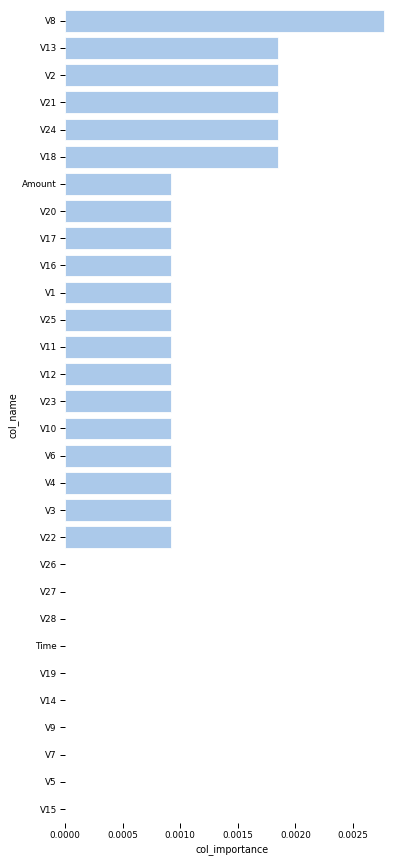

In [191]:
# use m
imp_result_drop_acc = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_drop_acc[item] = abs(imp[i])
importance_plot(imp_result_drop_acc)

In [193]:
## log_loss as metric
imp = dropcol_importances(model,X_train, y_train, X_valid, y_valid,log_loss,True)

[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current valu

[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current valu

Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07
Finished loading model, total used 100 iterations
[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, 

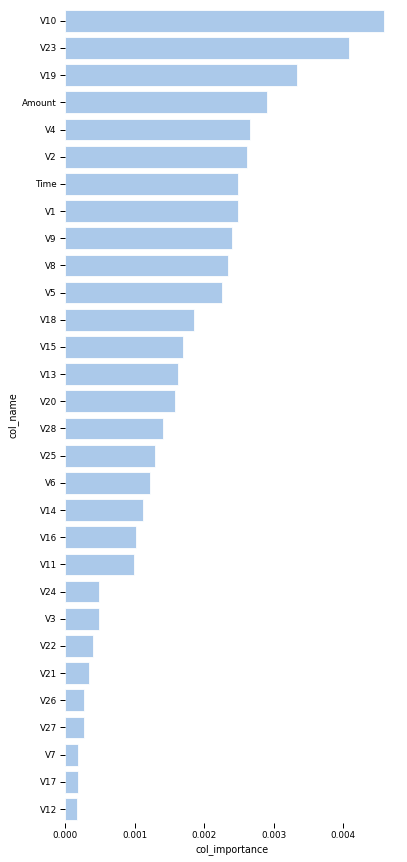

In [194]:
# use m
imp_result_drop_log = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_drop_log[item] = abs(imp[i])
importance_plot(imp_result_drop_log)

### Permutation Importance

In [156]:
model = lgb.LGBMClassifier(**param)
model.fit(X_train,y_train)

[LightGBM] [Warning] bagging_fraction is set=0.5584550389770908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584550389770908
[LightGBM] [Warning] feature_fraction is set=0.6998029478945647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6998029478945647
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.648254437122679e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.648254437122679e-07
[LightGBM] [Warning] lambda_l1 is set=7.902601989395657e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.902601989395657e-07


LGBMClassifier(bagging_fraction=0.5584550389770908, bagging_freq=4,
               feature_fraction=0.6998029478945647,
               lambda_l1=7.902601989395657e-07, lambda_l2=5.648254437122679e-07,
               max_depth=5, metric='binary_logloss', min_child_samples=60,
               num_leaves=67, objective='binary', verbose=-1)

In [161]:
def permutation_importances(model, X_valid, y_valid,metric,proba = False):
    if proba == True:
        baseline = metric(y_valid, model.predict_proba(X_valid))
    else:
        baseline = metric(y_valid, model.predict(X_valid))
    imp = []
    for col in X_valid.columns:
        save = X_valid[col].copy()
        X_valid[col] = np.random.permutation(X_valid[col])
        if proba == True:
            m = metric(y_valid, model.predict_proba(X_valid))
        else:
            m = metric(y_valid, model.predict(X_valid))
        X_valid[col] = save
        imp.append(baseline - m)
    return imp

In [195]:
imp = permutation_importances(model, X_valid, y_valid,accuracy_score,proba = False)

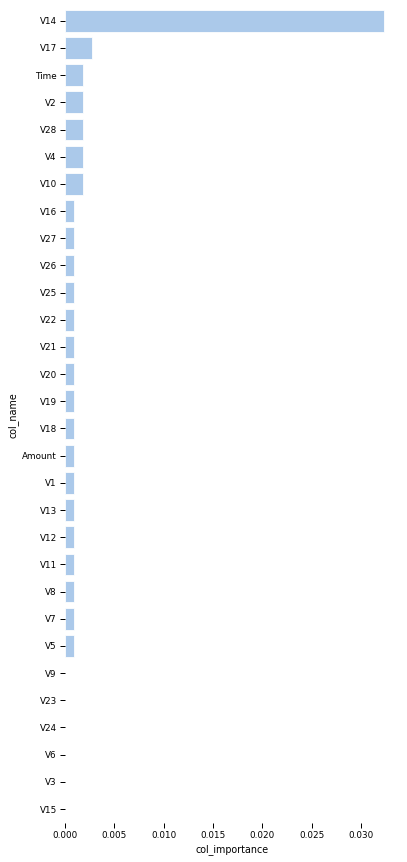

In [196]:
# use m
imp_result_permutation_acc = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_permutation_acc[item] = abs(imp[i])
importance_plot(imp_result_permutation_acc)

In [197]:
imp = permutation_importances(model, X_valid, y_valid,log_loss,proba = True)

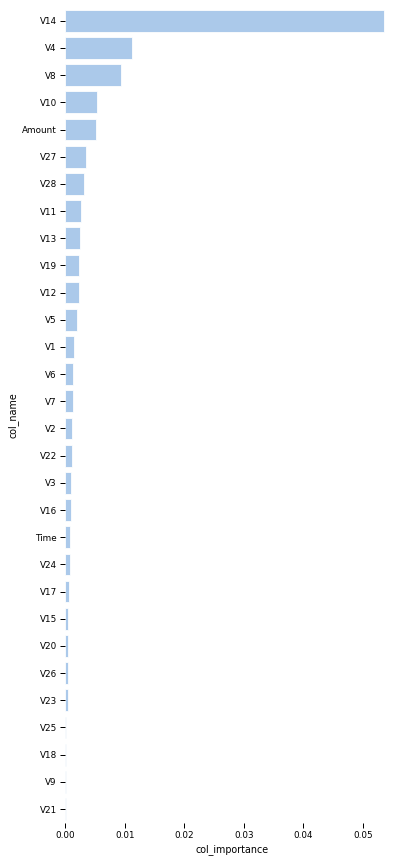

In [198]:
# use m
imp_result_permutation_log = defaultdict(float)
for i,item in enumerate(col_list):
    imp_result_permutation_log[item] = abs(imp[i])
importance_plot(imp_result_permutation_log)

### LightGBM Default Feature Importance

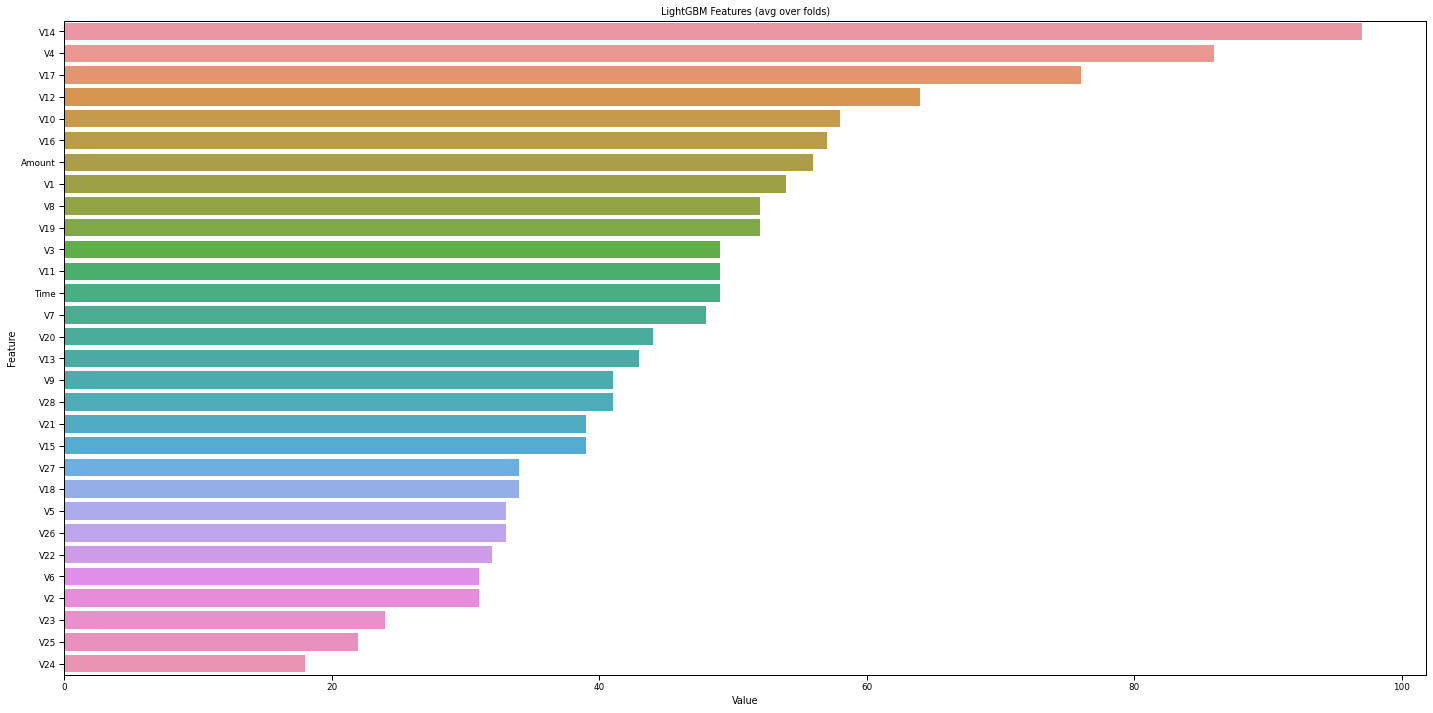

In [174]:
## LightGBM default feature importance
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Default Importance')
plt.tight_layout()
plt.show()

### SHAP

In [275]:
import shap
shap.initjs()
shap_values = shap.TreeExplainer(model).shap_values(X_valid)

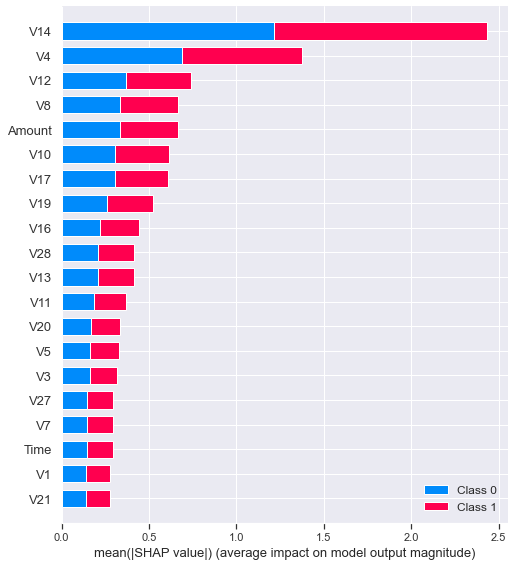

In [276]:
shap.summary_plot(shap_values, X_valid)

In [250]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
14,V14,1317.113029
4,V4,745.368070
12,V12,402.238080
8,V8,361.554340
29,Amount,360.981563
10,V10,332.565777
17,V17,331.064427
19,V19,284.044797
16,V16,238.635295
28,V28,224.174521


# Feature Importance Comparison

In [ ]:
#Spearman: importance_spearman
#PCA: importance_pca
#mRMR: importance_mRMR
#Drop Column Importance with accuracy: imp_result_drop_acc
#Drop Column Importance with log loss: imp_result_drop_log
#Permutation Importance with accuracy: imp_result_permutation_acc
#Permutation Importance with log loss: imp_result_permutation_log
#LightGBM default: feature_imp
#Shap: feature_importance

In [257]:
def get_order_from_imp_dict(imp):
    return [k for k, _ in sorted(imp.items(), key=lambda item: item[1], reverse=True)]
importance_spearman_order = get_order_from_imp_dict(importance_spearman)
importance_pca_order = get_order_from_imp_dict(importance_pca)
importance_mRMR_order = get_order_from_imp_dict(importance_mRMR)
importance_drop_acc_order = get_order_from_imp_dict(imp_result_drop_acc)
importance_drop_log_order = get_order_from_imp_dict(imp_result_drop_log)
importance_permutation_acc_order = get_order_from_imp_dict(imp_result_permutation_acc)
importance_permutation_log_order = get_order_from_imp_dict(imp_result_permutation_log)
importance_lgbm_defualt = list(feature_imp.Feature)[::-1]

In [251]:
importance_shap_defualt = list(feature_imp.Feature)

In [253]:
def loss_feature_lgbm(X,y,order_list,num_feature = 8):
    loss_list = []
    folds = 5
    seed = 42
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)
    
    params = {'objective': 'binary'}
    for i in range(num_feature):
        X_ = X[order_list[:i+1]]
        loss = 0
        for train_idx, valid_idx in kf.split(X_, y):
            train_x,train_y = X_.iloc[train_idx,:], y[train_idx]
            valid_x,valid_y = X_.iloc[valid_idx,:], y[valid_idx]
            model = lgb.LGBMClassifier()
            model.fit(train_x,train_y)
            y_pred = model.predict_proba(valid_x)
            loss += log_loss(valid_y, y_pred)
        loss = loss/folds
        loss_list.append(loss)
    return loss_list

In [258]:
imp_spearman_loss = loss_feature_lgbm(X_train,y_train,importance_spearman_order)
imp_pca_loss = loss_feature_lgbm(X_train,y_train,importance_pca_order)
imp_mRMR_loss = loss_feature_lgbm(X_train,y_train,importance_mRMR_order)
imp_drop_acc_loss = loss_feature_lgbm(X_train,y_train,importance_drop_acc_order)
imp_drop_log_loss = loss_feature_lgbm(X_train,y_train,importance_drop_log_order)
imp_permutation_acc_loss = loss_feature_lgbm(X_train,y_train,importance_permutation_acc_order)
imp_permutation_log_loss = loss_feature_lgbm(X_train,y_train,importance_permutation_log_order)
imp_lgbm_loss = loss_feature_lgbm(X_train,y_train,importance_lgbm_defualt)
imp_shap_loss = loss_feature_lgbm(X_train,y_train,importance_shap_defualt)

In [269]:
num_features = list(range(1,9))
data_preproc = pd.DataFrame({
    'Number of Feature': num_features, 
    'Spearman Loss': imp_spearman_loss,
    'PCA Loss': imp_pca_loss,
    'mRMR Loss': imp_mRMR_loss,
    'Drop Column Accuracy Loss': imp_drop_acc_loss,
    'Drop Column Log Loss': imp_drop_log_loss,
    'Permutation Accuracy Loss': imp_permutation_acc_loss,
    'Permutation Log Loss':imp_permutation_log_loss,
    'LightGBM Default Loss':imp_lgbm_loss,
    'SHAP Loss':imp_shap_loss})

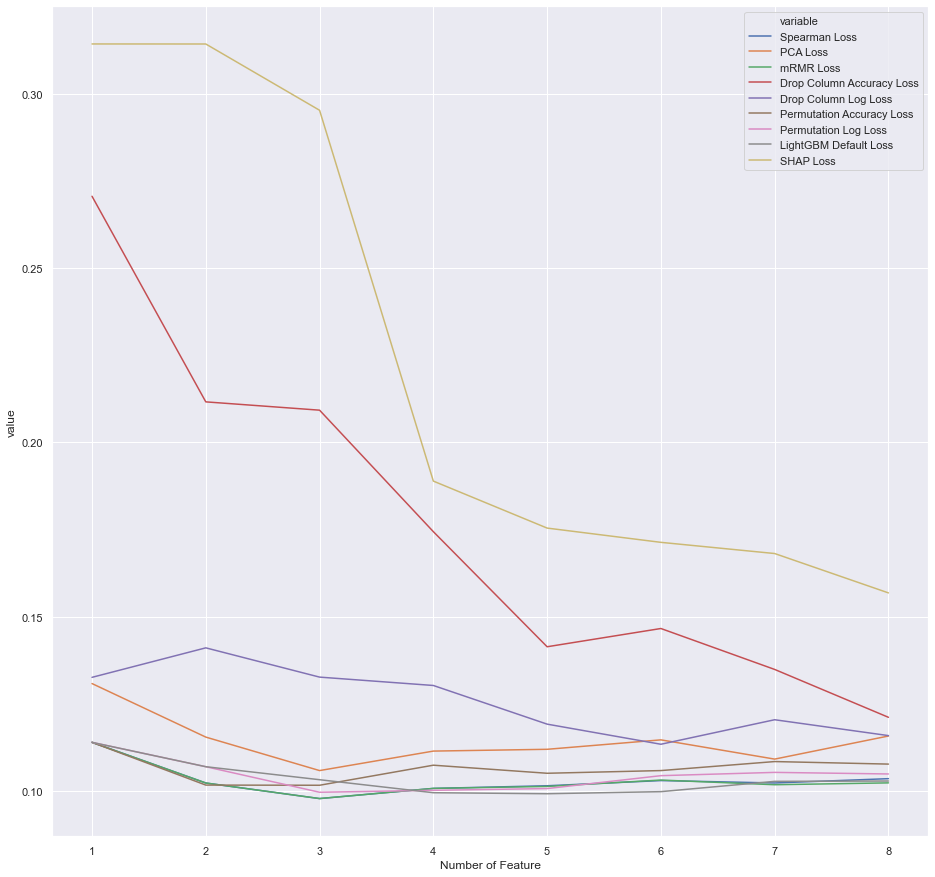

In [272]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
sns.lineplot(x='Number of Feature', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Number of Feature']))

This is just a initial attempt to see which feature importance method is good, the comparision is actually sensitive to model's parameter. From plot we notice: 
* The best feature importance search methods are <b>LightGBM default feature importance</b> and <b>mRMR feature importance</b>. 
* For <b>Drop Column</b> and <b>Permutation</b> methods, they are sensitive to evaluation metric. For binary classification problem, log loss performs better than accuracy.
* <b>Permutation</b> is better than <b>Drop Column</b>, maybe because <b>Drop Column</b> method's models are not fully tuned.
* <b>SHAP</b> is the worst for some reason.

# Automatic Feature Searching

# References

* https://github.com/slundberg/shap
* https://github.com/parrt/msds621/blob/master/lectures/feature-importance.pdf
